In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

import parse_results as pr
   
CHUNK_COLOR_MAP = {
    '64mb': 'blue',
    '128mb': 'green',
    '256mb': 'silver',
    '512mb': 'red'
}


def line_plot(points, color_map, title, xlabel='File size (gb)', ylabel='Time (s)', fixy=True):
    fig = plt.figure()
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    for k, v in points.iteritems():
        v = np.array(v)
        v.sort(axis=0)
        ax.plot(v[:,0], v[:,1], c=color_map[k], label=k, marker="o", linewidth=2)

    if fixy:
        ax.set_ylim(ymin=0) # must be after plot
    plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=1)
    plt.show()

def plot_ingestion_chunks(backend_name):
    results = pr.main(backend_name)
    data = results['ingestion']
    points = defaultdict(list)
    for k, v in data.iteritems():
        x = int(k[1][:-2])
        y = v
        points[k[2]].append((x, y)) # key by chunk size
        
    title = "Ingestion Results: " + backend_name
    line_plot(points, CHUNK_COLOR_MAP, title)

def plot_precompute_chunks(backend_name, key):
    results = pr.main(backend_name)
    data = results['precompute']
    points = defaultdict(list)
    for k, v in data.iteritems():
        if k[0] == key:
            x = int(k[2][:-2])
            y = v
            points[k[3]].append((x,y)) # key by chunk size
    
    title = "Precompute Results " + backend_name + "-" + key
    line_plot(points, CHUNK_COLOR_MAP, title)

First lets compare chunk sizes within a single backend to see how chunk sizes related to runtime and if there is a best overall chunk.

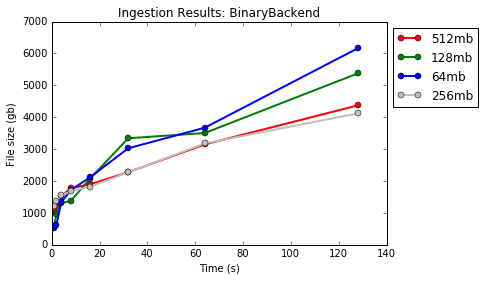

In [9]:
plot_ingestion_chunks("BinaryBackend")

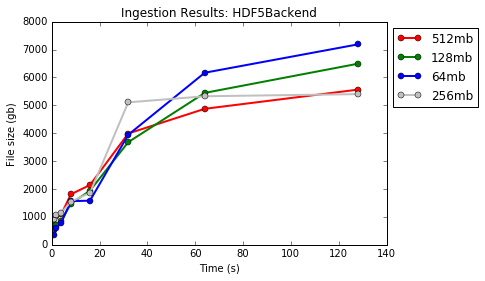

In [10]:
plot_ingestion_chunks("HDF5Backend")

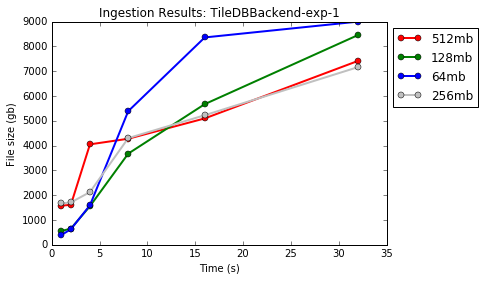

In [11]:
plot_ingestion_chunks("TileDBBackend-exp-1")

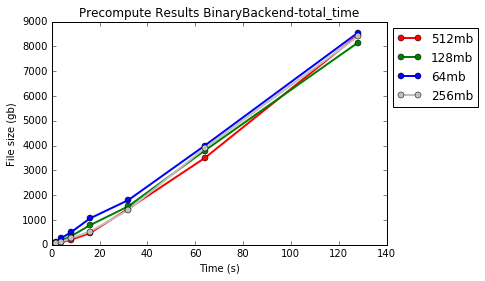

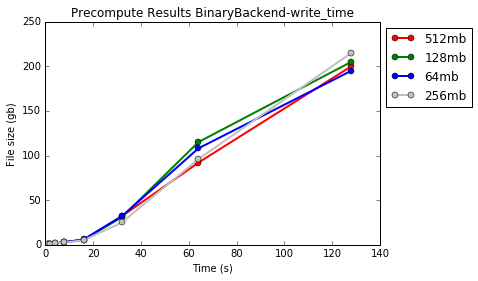

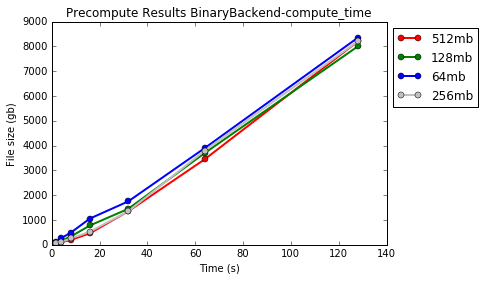

In [12]:
plot_precompute_chunks("BinaryBackend", "total_time")
plot_precompute_chunks("BinaryBackend", "write_time")
plot_precompute_chunks("BinaryBackend", "compute_time")

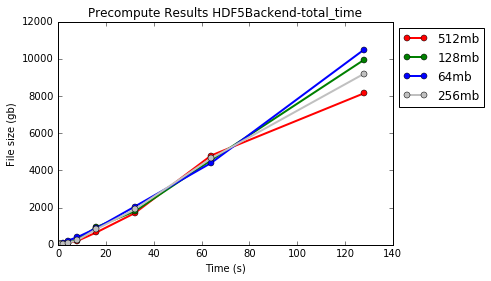

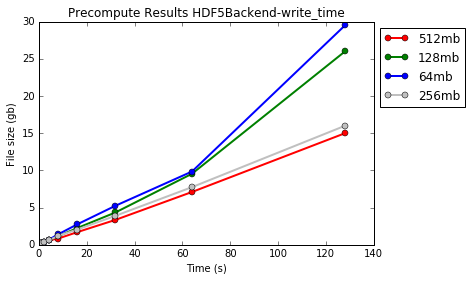

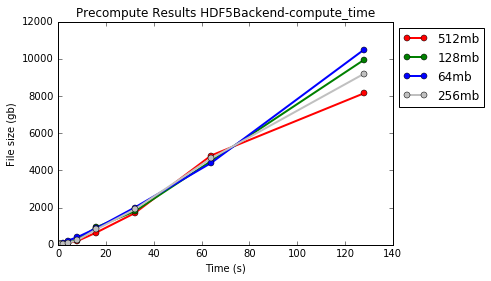

In [13]:
plot_precompute_chunks("HDF5Backend", "total_time")
plot_precompute_chunks("HDF5Backend", "write_time")
plot_precompute_chunks("HDF5Backend", "compute_time")

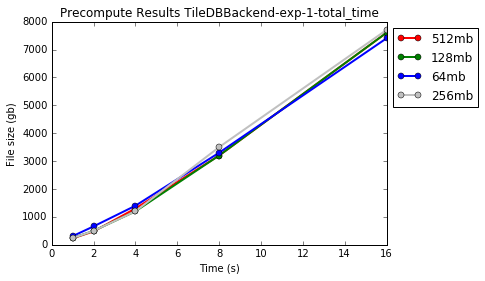

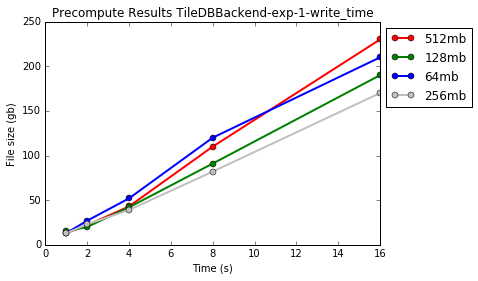

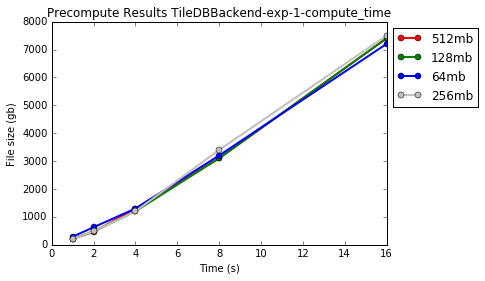

In [14]:
plot_precompute_chunks("TileDBBackend-exp-1", "total_time")
plot_precompute_chunks("TileDBBackend-exp-1", "write_time")
plot_precompute_chunks("TileDBBackend-exp-1", "compute_time")

In [5]:
CHUNK_SIZE = "256mb" # It seems like this is the best chunk size, so lets compare each backend with this chunk size.
BACKEND_EXPERIMENTS = [  
    'TileDBBackend',
    'HDF5Backend',
    'BinaryBackend',
]
BACKEND_COLOR_MAP = {
    'TileDBBackend': 'blue',
    'HDF5Backend': 'green',
    'BinaryBackend': 'silver',
}

def plot_ingestion_backends():
    points = defaultdict(list)
    for backend_name in BACKEND_EXPERIMENTS:
        results = pr.main(backend_name)
        data = results['ingestion']
        for k, v in data.iteritems():
            if k[2] == CHUNK_SIZE:
                x = int(k[1][:-2])
                y = v
                points[backend_name].append((x,y)) # key by chunk size
                
    title = "Ingestion Results: Chunk Size " + CHUNK_SIZE.upper()
    line_plot(points, BACKEND_COLOR_MAP, title)
    
def plot_precompute_backends(key):
    points = defaultdict(list)
    for backend_name in BACKEND_EXPERIMENTS:
        results = pr.main(backend_name)
        data = results['precompute']
        # combine the region read times into a single read time
        new_data = defaultdict(list)
        for k, v in data.iteritems():
            if 'read_time' in k[0]:
                new_key = list(k)
                new_key[0] = 'read_time'
                new_key = tuple(new_key)
                if not len(new_data[new_key]):
                    new_data[new_key] = [0]
                new_data[new_key][0] += v
        data.update(pr.avg_values(new_data))
            
        for k, v in data.iteritems():
            if k[3] == CHUNK_SIZE and k[0] == key:
                x = int(k[2][:-2])
                y = v
                points[backend_name].append((x,y)) # key by chunk size
    key = key.replace('_', ' ').title()
    title = "Precompute Results: " + key
    line_plot(points, BACKEND_COLOR_MAP, title)

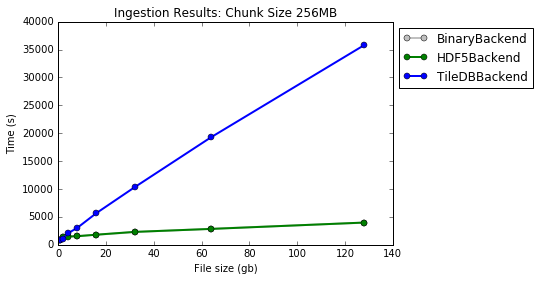

In [97]:
plot_ingestion_backends()

File precompute_results.txt-TileDBBackend-iso-2 not found.
2
File ingestion_results.txt-TileDBBackend-iso-2 not found.
2
File precompute_results.txt-HDF5Backend-iso-4 not found.
4
File ingestion_results.txt-HDF5Backend-iso-4 not found.
4
File precompute_results.txt-BinaryBackend-iso-4 not found.
4
File ingestion_results.txt-BinaryBackend-iso-4 not found.
4


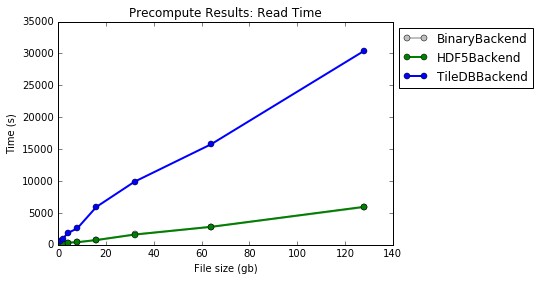

File precompute_results.txt-TileDBBackend-iso-2 not found.
2
File ingestion_results.txt-TileDBBackend-iso-2 not found.
2
File precompute_results.txt-HDF5Backend-iso-4 not found.
4
File ingestion_results.txt-HDF5Backend-iso-4 not found.
4
File precompute_results.txt-BinaryBackend-iso-4 not found.
4
File ingestion_results.txt-BinaryBackend-iso-4 not found.
4


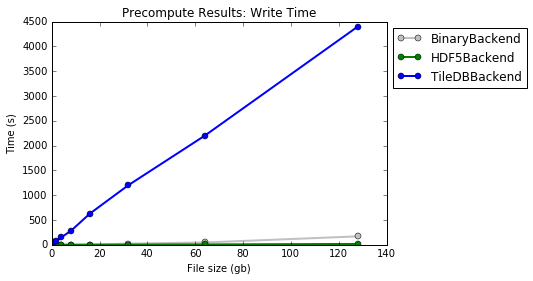

File precompute_results.txt-TileDBBackend-iso-2 not found.
2
File ingestion_results.txt-TileDBBackend-iso-2 not found.
2
File precompute_results.txt-HDF5Backend-iso-4 not found.
4
File ingestion_results.txt-HDF5Backend-iso-4 not found.
4
File precompute_results.txt-BinaryBackend-iso-4 not found.
4
File ingestion_results.txt-BinaryBackend-iso-4 not found.
4


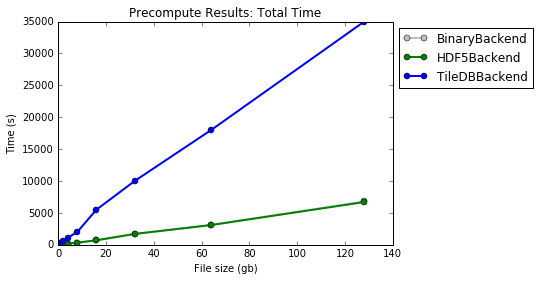

In [6]:
plot_precompute_backends('read_time')
plot_precompute_backends('write_time')
plot_precompute_backends('total_time')

In [62]:
GB = 1000000000
BACKEND_NAMES = {  
    'TileDBBackend' : 'TileDB', 
    'HDF5Backend' : 'HDF5', 
    'BinaryBackend' : 'Binary',
}
EXPECTED_SIZES = {
    '1gb': 1*GB,
    '2gb': 2*GB,
    '4gb': 4*GB,
    '8gb': 8*GB,
    '16gb': 16*GB,
    '32gb': 32*GB,
    '64gb': 64*GB,
    '128gb': 128*GB,
}

def storage_overhead():
    file_sizes = extract_all()
    points = defaultdict(list)

    for backend_name, pretty_name in BACKEND_NAMES.iteritems():
        for expected_size, byte_size in EXPECTED_SIZES.iteritems():
            y = 100 * (file_sizes[backend_name].get(expected_size, 0)/float(byte_size)) - 100 # percent overhead
            points[pretty_name].append(y)
        max_overhead = round(max(points[pretty_name]), 2)
        avg_overhead = round(np.average(points[pretty_name]), 2)
        print '{backend}: Max Overhead: {max_overhead}%, Avg. Overhead: {avg_overhead}%'.format(backend=pretty_name,
                                                                                             max_overhead=max_overhead,
                                                                                              avg_overhead=avg_overhead)

In [63]:
storage_overhead()

Binary: Max Overhead: 0.0%, Avg. Overhead: 0.0%
HDF5: Max Overhead: 2.4%, Avg. Overhead: 1.5%
TileDB: Max Overhead: 38.01%, Avg. Overhead: 38.01%
